In [1]:
import os, os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
DATA_DIR = '/home/chandan/Documents/datasets/talkingdata-adtracking-fraud-detection'

In [3]:
train = pd.read_csv(osp.join(DATA_DIR, 'train_sample.csv'))
test = pd.read_csv(osp.join(DATA_DIR, 'test.csv'))

X = pd.DataFrame()
Y = pd.DataFrame()

In [4]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [5]:
# attributes
train.columns

Index([u'ip', u'app', u'device', u'os', u'channel', u'click_time',
       u'attributed_time', u'is_attributed'],
      dtype='object')

## Train

- ip: ip address of click.
   - encoding: int
   - IP address dont have a >, < ordering
   - closer IP addresses may be geographically closer
   - transform: bin it and make it categorical?
- app: app id for marketing.
    - encoding: 
- device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
    - encoding: 
- os: os version id of user mobile phone
    - encoding: 
- channel: channel id of mobile ad publisher
- click_time: timestamp of click (UTC)
- attributed_time: if user download the app for after clicking an ad, this is the time of the app download
- is_attributed: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

## Test

- click_id: reference for making predictions
- is_attributed: not included

('distinct values:', array([357]))


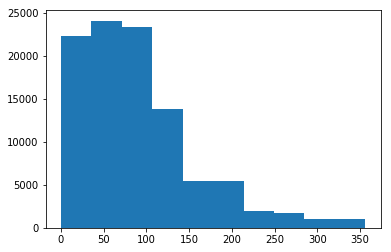

In [33]:
# ip address - divide into 1000 bins
from sklearn.preprocessing import OneHotEncoder

num_ip_bins = 1024
binned_ips = (train.ip / num_ip_bins).astype(int) 

enc = OneHotEncoder()
enc.fit(binned_ips.values.reshape((-1, 1)))
print('distinct values:', enc.n_values_)

plt.hist(binned_ips)

X['ip'] = enc.transform(binned_ips.values.reshape((-1, 1)))


In [ ]:
# convert click time to time or day, weekend indicator, day of week

In [ ]:
# remove attributed time

In [ ]:
# hash the device ID - has too many unique values

In [ ]:
# logistic regression

In [ ]:
# SGD classifier with partial fit